In this notebook we calculate some values which will be useful in preprocessing the EUMETSAT and UKV data (min, max, mean, std etc) and upload them to the GCP bucket. 

Currently these aggregate statistic values are calculated over less than a full year, so ideally this will be rerun once more data is available.

In [1]:
from src.data.constants import GCP_FS
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask

import os
import gcsfs

/opt/conda/lib/python3.7/site-packages/pvlib/solarposition.py:265: UserWarning: Reloading spa to use numba
  warnings.warn('Reloading spa to use numba')


In [15]:
def aggregates(ds, dim):
    """Function to calculate various aggregates to be used in pre-processing data."""
    agg = {}
    agg['mean'] = ds.mean(dim=dim)
    agg['std'] = ds.std(dim=dim)
    agg['min'] = ds.min(dim=dim)
    agg['max'] = ds.max(dim=dim)
    # need min for next section so do first round of computation now
    (agg['mean'],agg['std'], 
     agg['min'], agg['max']) = dask.compute(*[agg[k] for k in ['mean','std','min','max']])
    
    log_ds = np.log(ds - agg['min'] + 1)
    agg['mean_log'] = log_ds.mean(dim=dim)
    agg['std_log'] = log_ds.std(dim=dim)
    agg['min_log'] = log_ds.min(dim=dim)
    agg['max_log'] = log_ds.max(dim=dim)
    
    # combine and compute
    agg_ds = xr.concat([ds.assign_coords(aggregate_statistic=[k]) 
                            for k, ds in agg.items()], 
                       dim='aggregate_statistic').compute()
    agg_ds.attrs = ds.attrs
    agg_ds.attrs['log_calculation_note'] = "Calculated from log(x-x.min()+1)"
    return agg_ds

In [16]:
agg_dir = os.path.expanduser("~/agg_data")
os.makedirs(agg_dir, exist_ok=True)

## Satellite aggrgate stats

Note this is only calculated from Jan, Feb and June 2019. See graph further below for times

In [17]:
SATELLITE_ZARR_PATH = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/OSGB36/zarr'
SATELLITE_STORE = gcsfs.mapping.GCSMap(SATELLITE_ZARR_PATH, gcs=GCP_FS, 
                                       check=True, create=False)

In [18]:
sat_ds = xr.open_zarr(store=SATELLITE_STORE, consolidated=True)
sat_ds

<xarray.Dataset>
Dimensions:                (time: 24472, variable: 12, x: 548, y: 704)
Coordinates:
  * time                   (time) datetime64[ns] 2019-01-01T00:04:00 ... 2019-06-30T23:54:00
  * variable               (variable) <U6 'HRV' 'IR_016' ... 'WV_062' 'WV_073'
  * x                      (x) int64 -238000 -236000 -234000 ... 854000 856000
  * y                      (y) int64 1222000 1220000 1218000 ... -182000 -184000
Data variables:
    stacked_eumetsat_data  (time, y, x, variable) float32 dask.array<chunksize=(1, 704, 548, 12), meta=np.ndarray>

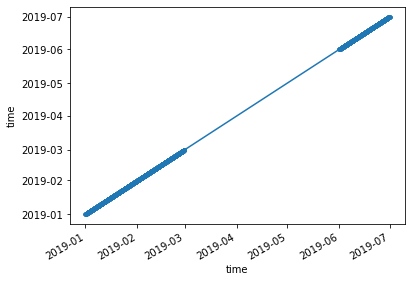

In [19]:
sat_time_message="""Dates from 2019 Jan, Feb and June. Sample every ~25mins"""

sl = slice(None, None, 5)

sat_ds_filtered = sat_ds.isel(time=sl)
sat_ds_filtered.time.plot(marker='.')
plt.show()

In [20]:
%time sat_aggs = aggregates(sat_ds_filtered, dim=('x', 'y', 'time'))
sat_aggs

<xarray.Dataset>
Dimensions:                (aggregate_statistic: 8, variable: 12)
Coordinates:
  * variable               (variable) <U6 'HRV' 'IR_016' ... 'WV_062' 'WV_073'
  * aggregate_statistic    (aggregate_statistic) object 'mean' ... 'max_log'
Data variables:
    stacked_eumetsat_data  (aggregate_statistic, variable) float32 7.8766136 ... 4.1392198
Attributes:
    log_calculation_note:  Calculated from log(x-x.min()+1)

In [21]:
sat_aggs.attrs['time-range'] = sat_time_message

# save locally just to avoid losing the calculaion somehow
sat_aggs.to_netcdf(f"{agg_dir}/sat_aggs.nc")

In [24]:
# upload to zarr store
SATELLITE_AGG_PATH = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/OSGB36/aggregate'
SATELLITE_AGG_STORE = gcsfs.mapping.GCSMap(SATELLITE_AGG_PATH, gcs=GCP_FS, check=True, create=True)
sat_aggs.to_zarr(store=SATELLITE_AGG_STORE, consolidated=True)

## NWP aggrgate stats

Note this is only calculated for 2019 for all the year except a chunk in peak of summer. See graph further below for times

In [25]:
NWP_ZARR_PATH1 = 'solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_zarr/2019_1-6'
NWP_STORE1 = gcsfs.mapping.GCSMap(NWP_ZARR_PATH1, gcs=GCP_FS, 
                                       check=True, create=False)

NWP_ZARR_PATH2 = 'solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_zarr/2019_7-12'
NWP_STORE2 = gcsfs.mapping.GCSMap(NWP_ZARR_PATH2, gcs=GCP_FS, 
                                       check=True, create=False)

nwp_ds1 = xr.open_zarr(store=NWP_STORE1, consolidated=True)
nwp_ds2 = xr.open_zarr(store=NWP_STORE2, consolidated=True)
nwp_ds = xr.concat([nwp_ds1, nwp_ds2], dim='time')

del nwp_ds1, nwp_ds2

nwp_ds

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 15, step: 37, time: 2722, x: 548, y: 704)
Coordinates:
  * step           (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * y              (y) float64 -1.84e+05 -1.82e+05 ... 1.22e+06 1.222e+06
  * x              (x) float64 -2.38e+05 -2.36e+05 ... 8.54e+05 8.56e+05
  * isobaricInhPa  (isobaricInhPa) int64 1000 925 850 700 600 ... 100 70 50 30
  * time           (time) datetime64[ns] 2019-01-01 ... 2019-12-24T12:00:00
Data variables:
    cdcb           (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    dlwrf          (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    dpt            (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    dswrf          (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    gh_p           (time, step, y, x, isobaricInhPa) float32 dask.array<chunksize=(1, 10, 704, 548, 5), meta=np.ndarray>
    gust10         (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    gust10_m       (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    h              (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    hcc            (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    hcct           (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    lcc            (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    mcc            (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    prate          (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    prmsl          (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    r              (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    r_p            (time, step, y, x, isobaricInhPa) float32 dask.array<chunksize=(1, 10, 704, 548, 5), meta=np.ndarray>
    sde            (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    si10           (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    t              (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    t_p            (time, step, y, x, isobaricInhPa) float32 dask.array<chunksize=(1, 10, 704, 548, 5), meta=np.ndarray>
    unknown_1      (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    unknown_2      (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    unknown_3      (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    unknown_4      (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    vis            (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    wdir10         (time, step, y, x) float32 dask.array<chunksize=(1, 10, 704, 548), meta=np.ndarray>
    wdir_p         (time, step, y, x, isobaricInhPa) float32 dask.array<chunksize=(1, 10, 704, 548, 5), meta=np.ndarray>
    ws_p           (time, step, y, x, isobaricInhPa) float32 dask.array<chunksize=(1, 10, 704, 548, 5), meta=np.ndarray>

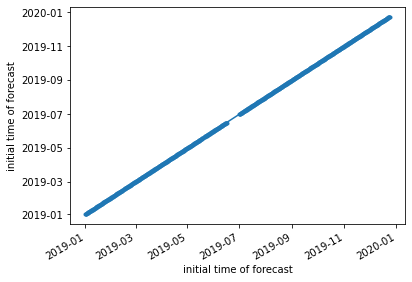

In [28]:
# Don't need 37 hours per 3-hourly forecast. Take every n-th forecast and m-th valid time
nwp_time_message="""Dates from all 2019 except missing half of June. Took one forecast every 9 hours and take forecast step every 2 hours"""

nwp_sl_time = slice(None, None, 3)
nwp_sl_step = slice(None, None, 2)

nwp_ds_filtered = nwp_ds.isel(time=nwp_sl_time, step=nwp_sl_step)

nwp_ds_filtered.time.plot(marker='.')
plt.show()

In [ ]:
%time nwp_aggs = aggregates(nwp_ds_filtered, dim=('x', 'y', 'time', 'step'))
nwp_aggs

/opt/conda/lib/python3.7/site-packages/dask/utils.py:30: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


In [ ]:
nwp_aggs.attrs['time-range'] = nwp_time_message

nwp_aggs.to_netcdf(f"{agg_dir}/nwp_aggs.nc")

In [ ]:
# upload to zarr store
NWP_AGG_PATH = 'solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_zarr/aggregate'
NWP_AGG_STORE = gcsfs.mapping.GCSMap(NWP_AGG_PATH, gcs=GCP_FS, check=True, create=True)
nwp_aggs.to_zarr(store=NWP_AGG_STORE, consolidated=True)

In [31]:
nwp_sl_time

slice(None, None, 3)

In [32]:
nwp_aggs

NameError: name 'nwp_aggs' is not defined